# 0. Preparación de la notebook

## Dependencias

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import geopandas as gpd


## Constantes

In [2]:
VERDE = "#196F3D"
AZUL = "#2874A6"
NARANJA = "#DC7633"
VIOLETA = "#8E44AD"
GRIS = "#B2BABB"
COLORES = [VERDE, AZUL, NARANJA, VIOLETA]

## Funciones

### Grafico de barras

In [3]:
def plot_graph(df_to_graph, title, xlabel, ylabel):

  plt.figure(figsize=(10, 6))
  df_to_graph.plot(kind="bar")
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.xticks(rotation=90)
  plt.grid(axis="y", linestyle="--", alpha=0.7)
  plt.tight_layout()
  plt.show()

In [4]:
def grafico_correlacion_por_categoría(colX, colY, colCualit):
    categorias = df[colCualit].unique()
    correlaciones = []

    for categoria in categorias:
        subset = df[df[colCualit] == categoria]
        correlacion = subset[colX].corr(subset[colY])
        correlaciones.append(correlacion)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=categorias, y=correlaciones)
    plt.title(f"Correlación entre {colX} y {colY} por {colCualit}")
    plt.xlabel(colCualit)
    plt.ylabel("Correlación")
    plt.xticks(rotation=45)
    plt.show()

In [5]:
def grafico_porcentaje_nulls_por_fila():
  promedio_no_nulos = df.notnull().sum(axis=1).mean()
  promedio_nulos = df.isnull().sum(axis=1).mean()

  total = promedio_no_nulos + promedio_nulos

  porcentaje_no_nulos = promedio_no_nulos / total * 100
  porcentaje_nulos = promedio_nulos / total * 100

  etiquetas = ["Promedio por fila"]
  valores_no_nulos = [porcentaje_no_nulos]
  valores_nulos = [porcentaje_nulos]

  plt.figure(figsize=(8, 6))

  plt.bar(etiquetas, valores_no_nulos, color="lightblue", label="Valores no nulos")
  plt.bar(etiquetas, valores_nulos, bottom=valores_no_nulos, color="lightcoral", label="Valores nulos")

  plt.title("Porcentaje promedio de valores no nulos y nulos por fila")
  plt.xlabel("Promedio por fila")
  plt.ylabel("Porcentaje (%)")
  plt.legend()

  plt.show()

In [6]:
def graficar_correlaciones_superficie_por_tipo_de_propiedad():
  correlation_by_place_l3 = df_departamentos.groupby("place_l3").apply(lambda x: x["property_surface_covered"].corr(x["property_surface_total"]))

  plt.figure(figsize=(12, 6))
  sns.barplot(x=correlation_by_place_l3.index, y=correlation_by_place_l3.values, color=AZUL)
  plt.title("Correlación entre superficie cubierta y superficie total por place_l3 (Departamentos)")
  plt.xlabel("place_l3")
  plt.ylabel("Correlación")
  plt.xticks(rotation=90)
  plt.tight_layout()
  plt.show()

In [7]:
def graficar_correlaciones_superficie_por_place_l3():
  muestras_por_place_l3 = df_departamentos.groupby("place_l3").size()

  plt.figure(figsize=(12, 6))
  sns.barplot(x=muestras_por_place_l3.index, y=muestras_por_place_l3.values, color=VERDE)
  plt.title("Cantidad de muestras por place_l3 (Departamentos)")
  plt.xlabel("place_l3")
  plt.ylabel("Cantidad de muestras")
  plt.xticks(rotation=90)
  plt.tight_layout()
  plt.show()

### Torta

In [8]:
def grafico_pie_correlacion_por_tipo_y_barrio():

  # Obtengo correlación entre la superficie total y cubierta para cada tipo de propiedad
  correlation_by_type = df.groupby("property_type").apply(lambda x: x["property_surface_total"].corr(x["property_surface_covered"]))

  correlation_by_place_l3 = df_departamentos.groupby("place_l3").apply(lambda x: x["property_surface_covered"].corr(x["property_surface_total"]))

  correlation_by_place_l3_sorted = correlation_by_place_l3.sort_values(ascending=False)

  total_values = len(correlation_by_place_l3)

  # Calcular los porcentajes
  percent_nan = (correlation_by_place_l3.isnull().sum() / total_values) * 100
  percent_08 = (np.sum(correlation_by_place_l3[correlation_by_place_l3 >= 0.8]) / total_values) * 100
  percent_lt_09 = (np.sum(correlation_by_place_l3[(correlation_by_place_l3 >= 0) & (correlation_by_place_l3 < 0.8)]) / total_values) * 100

  # Etiquetas y valores para el gráfico
  labels = ["NaN", ">= 0.8", "< 0.8"]
  percentages = [percent_nan, percent_08, percent_lt_09]

  # Graficar
  plt.pie(percentages, labels=labels, autopct="%1.1f%%", colors=[AZUL, VERDE, "orange"])
  plt.title("Porcentaje de valores en la correlación entre superficie cubierta y total para departamentos")
  plt.show()

### Distribuciones

In [9]:
def mostrar_distros_cuantitativas(columna):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=columna)
    plt.title(f"Cantidad de muestras por {columna}")
    plt.xlabel(columna)
    plt.ylabel("Cantidad de muestras")
    plt.xticks(rotation=45)
    plt.show()

In [10]:
def mostrar_distros_cuantitativas_continuas(columna):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=columna, bins=40)
    plt.title(f"Cantidad de muestras por {columna}")
    plt.xlabel(columna)
    plt.ylabel("Cantidad de muestras")
    plt.xticks(rotation=45)
    plt.show()

In [11]:
def mostrar_distros_cualitativas(columna):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    axes[0].hist(_df[columna], bins=30, color=AZUL, alpha=0.7)
    axes[0].set_xlabel("Valores")
    axes[0].set_ylabel("Frecuencia")
    axes[0].set_title("Histograma")

    sns.boxplot(data=_df[columna], ax=axes[1], color=VERDE)
    axes[1].set_ylabel("Valores")
    axes[1].set_title("Boxplot")

    fig.suptitle(f"Distribución de {columna}")
    plt.tight_layout()
    plt.show()

### Dispersión

In [12]:
def mostrar_dispersion(colX, colY):
  plt.scatter(df[colX], df[colY])
  plt.xlabel(colX)
  plt.ylabel(colY)
  plt.title(f"Dispersión entre {colX} y {colY}")
  plt.show()

In [13]:
def mostrar_dispersion_3d(colX,colY,colZ):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    _colX = df[colX]
    _colY = df[colY]
    _colZ = df[colZ]

    ax.scatter(_colX, _colY, _colZ, c=AZUL, marker="o")

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.set_zlabel(colZ)

    ax.set_title(f"Dispersión 3D de {colX}, {colY} y {colZ}")

    plt.show()

In [14]:
def grafico_dispersión_aproximación_lineal(colX, colY):
    x = df[colX]
    y = df[colY]

    coeficientes = np.polyfit(x, y, 1)
    polinomio = np.poly1d(coeficientes)

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color=AZUL, label="Datos")
    plt.plot(x, polinomio(x), color="red", label="Aproximación lineal")
    plt.title(f"Aproximación lineal de {colX} y {colY}")
    plt.xlabel(colX)
    plt.ylabel(colY)
    plt.legend()
    plt.grid(True)
    plt.show()

### Heatmap

In [15]:
def graficar_heatmap(colsArr):
  plt.figure(figsize=(6, 4))
  ax = sns.heatmap(df[colsArr].corr(), annot=True)
  ax.set_title("Índice de correlación")
  plt.show()

## Lectura de datos

In [16]:
path_df = "properati_argentina_2021.csv"

In [17]:
df_raw = pd.read_csv(path_df)

# 1. Análisis exploratorio y preprocesamiento de datos

## Preparación del dataframe

### Vistazo inicial en crudo

In [18]:
df_raw.shape

(460154, 20)

In [19]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460154 entries, 0 to 460153
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        460154 non-null  object 
 1   start_date                460154 non-null  object 
 2   end_date                  460154 non-null  object 
 3   created_on                460154 non-null  object 
 4   latitud                   419740 non-null  float64
 5   longitud                  419740 non-null  float64
 6   place_l2                  460154 non-null  object 
 7   place_l3                  437665 non-null  object 
 8   place_l4                  139020 non-null  object 
 9   place_l5                  2430 non-null    object 
 10  place_l6                  0 non-null       float64
 11  operation                 460154 non-null  object 
 12  property_type             460154 non-null  object 
 13  property_rooms            368498 non-null  f

In [20]:
df_raw.head(3)

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay


### Filtrado

Vamos a analizar una parte de la información leida. Antes de realizar el filtrado indicado analizamos el contenido de las columnas involucradas en la selección de datos para prevenir errores filtrando.

Por ejemplo, si queremos filtrar publicaciones en dolares, cabría la posibilidad de que la columna `property_currency` tenga distintas formas de expresar el mismo valor. `USD`, `usd`, `Dolar estadounidense`, etc.

#### Visualización de valores de las columnas a filtrar

In [21]:
df_raw["operation"].value_counts()

operation
Venta                337874
Alquiler              98900
Alquiler temporal     23380
Name: count, dtype: int64

In [22]:
df_raw["property_type"].value_counts()

property_type
Departamento       231358
Casa               120768
Lote                28748
PH                  25910
Local comercial     20546
Oficina             16085
Otro                 7713
Cochera              4111
Depósito             4050
Casa de campo         865
Name: count, dtype: int64

In [23]:
df_raw["property_currency"].value_counts()

property_currency
USD    349104
ARS     88869
UYU      3506
PEN        99
COP        12
Name: count, dtype: int64

In [24]:
df_raw["place_l2"].value_counts()

place_l2
Capital Federal                 157563
Bs.As. G.B.A. Zona Norte         89693
Santa Fe                         47861
Bs.As. G.B.A. Zona Sur           47754
Bs.As. G.B.A. Zona Oeste         28352
Córdoba                          22528
Buenos Aires Costa Atlántica     12457
Neuquén                           8788
Montevideo                        7494
Buenos Aires Interior             6274
Maldonado                         5540
Mendoza                           5395
Río Negro                         5280
Tucumán                           3571
Colonia                           2535
Salta                             1537
Entre Ríos                        1216
San Juan                           997
La Pampa                           783
Canelones                          744
Chubut                             701
San Luis                           677
Misiones                           529
Florida                            411
Jujuy                              406
Corrientes      

Viendo que los criterios de filtro no tienen variantes, realizamos el filtrado.
Como observación a tener en cuenta, el tipo de propiedades "Otro" podría llegar a tener información útil y con esta podríamos ampliar el dataframe obtenido.
Un ejemplo podría ser una "Casa de veraneo" que sea clasificada como  `Otro` en lugar de como `Casa`.

#### Filtrado

In [25]:
tipos_propiedades = ["Departamento", "Casa", "PH"]

df_raw = df_raw[(df_raw["property_currency"] == "USD") & (df_raw["operation"] == "Venta") & (df_raw["property_type"].isin(tipos_propiedades)) &
        (df_raw["place_l2"] == "Capital Federal")]


### División en dataframes de entrenamiento y prueba

Separamos el dataframe en prueba y entrenamiento

In [26]:
# Variando la seed se modifican los df de prueba y de entrenamiento. La idea es que quede fija.
seed = 123

_df, df_test = train_test_split(df_raw, test_size=0.2, random_state=seed)

df = _df # creo esta copia para luego poder comparar las distros antes y despues de imputar datos.

print(df_raw.shape)
print(_df.shape)
print(df_test.shape)

(94249, 20)
(75399, 20)
(18850, 20)


## A. Exploración inicial

### Variables cuantitativas

#### Discretas

Estas columnas son discretas ya que representan fechas pero no horas.

In [27]:
print(df["start_date"].min())
print(df["start_date"].max())

2021-01-01
2021-12-31


In [28]:
print(df["end_date"].min())
print(df["end_date"].max())

2021-01-02
9999-12-31


In [29]:
print(df["created_on"].min())
print(df["created_on"].max())

2021-01-01
2021-12-31


In [30]:
df["property_rooms"].mean(), df["property_rooms"].median(), df["property_rooms"].mode()[0]

(2.8221715512038092, 3.0, 3.0)

In [31]:
df["property_bedrooms"].mean(), df["property_bedrooms"].median(), df["property_bedrooms"].mode()[0]

(2.013289734205316, 2.0, 1.0)

#### Continuas

In [32]:
df["latitud"].mean(), df["latitud"].median(), df["latitud"].mode()[0]

(-34.59126352648724, -34.59573237315, -34.5412501)

In [33]:
df["longitud"].mean(), df["longitud"].median(), df["longitud"].mode()[0]

(-58.449369334704855, -58.4389166, -58.4729664)

In [34]:
df["property_surface_covered"].mean(), df["property_surface_covered"].median(), df["property_surface_covered"].mode()[0]

(89.04041959387932, 58.0, 40.0)

In [35]:
df["property_surface_total"].mean(), df["property_surface_total"].median(), df["property_surface_total"].mode()[0]

(109.0961073450276, 65.0, 50.0)

In [36]:
df["property_price"].mean(), df["property_price"].median(), df["property_price"].mode()[0]

(226092.01221501612, 144000.0, 110000.0)

### Variables Cualitativas


#### Place_l

Los distintos **place_l** son variables cualitativas. Buscamos los distintos valores que adoptan.


In [37]:
df["place_l2"].value_counts(dropna=False)

place_l2
Capital Federal    75399
Name: count, dtype: int64

In [38]:
df["place_l3"].value_counts(dropna=False)

place_l3
Palermo                 11448
Belgrano                 7173
Caballito                5688
Recoleta                 5031
Villa Urquiza            3794
Almagro                  3291
Nuñez                    2839
Villa Crespo             2563
Flores                   2460
Barrio Norte             2418
Balvanera                2071
Colegiales               1571
Villa Devoto             1533
Saavedra                 1447
Villa del Parque         1446
Puerto Madero            1207
San Telmo                1118
San Nicolás              1053
San Cristobal            1027
Barracas                 1011
Retiro                    984
Boedo                     972
Floresta                  950
Monserrat                 893
Parque Chacabuco          859
Villa Pueyrredón          792
Coghlan                   771
Villa Luro                574
Mataderos                 572
Chacarita                 550
Liniers                   536
Villa Ortuzar             512
Parque Patricios          494
V

In [39]:
df["place_l4"].value_counts(dropna=False)

place_l4
NaN                  72496
Palermo Hollywood     1245
Palermo Chico          874
Palermo Soho           648
Palermo Viejo          136
Name: count, dtype: int64

In [40]:
df["place_l5"].value_counts(dropna=False)

place_l5
NaN    75399
Name: count, dtype: int64

In [41]:
df["place_l6"].value_counts(dropna=False)

place_l6
NaN    75399
Name: count, dtype: int64

#### Otras cualitatias

In [42]:
df["operation"].value_counts(dropna=False)

operation
Venta    75399
Name: count, dtype: int64

In [43]:
df["property_type"].value_counts(dropna=False)

property_type
Departamento    64698
PH               7392
Casa             3309
Name: count, dtype: int64

In [44]:
df["property_currency"].value_counts(dropna=False)

property_currency
USD    75399
Name: count, dtype: int64

In [45]:
df["property_title"].value_counts(dropna=False)

property_title
Departamento - Palermo                                                                          1182
Departamento - Recoleta                                                                         1064
Departamento - Belgrano                                                                          893
Departamento - Caballito                                                                         753
Departamento - Almagro                                                                           541
                                                                                                ... 
Excelente departamento 4 amb. C/ Dep y cochera!!!!                                                 1
4 AMBIENTES COCINA INDEPENDIENTE CON BALCÓN AL FRENTE                                              1
VENTA depto 5 amb en esquina luminosa c/ terraza y quincho priv - Serrano 700,  Palermo Soho       1
Venta departamento 3 ambientes con baulera                                  

### Variables irrelevantes

En el apartado `1)A)Variables cualitativas` podemos notar que hay columnas cuyo valor se repite en todos los registros. De esta forma estas columnas no aportan información y pueden eliminarse.

In [46]:
df = df.drop("property_currency", axis=1)
df = df.drop("operation", axis=1)

En la misma sección tambien encontramos una alta presencia de `Null` en `place_l4`, `place_l5` y `place_l6`, por lo que tambien las eliminamos.

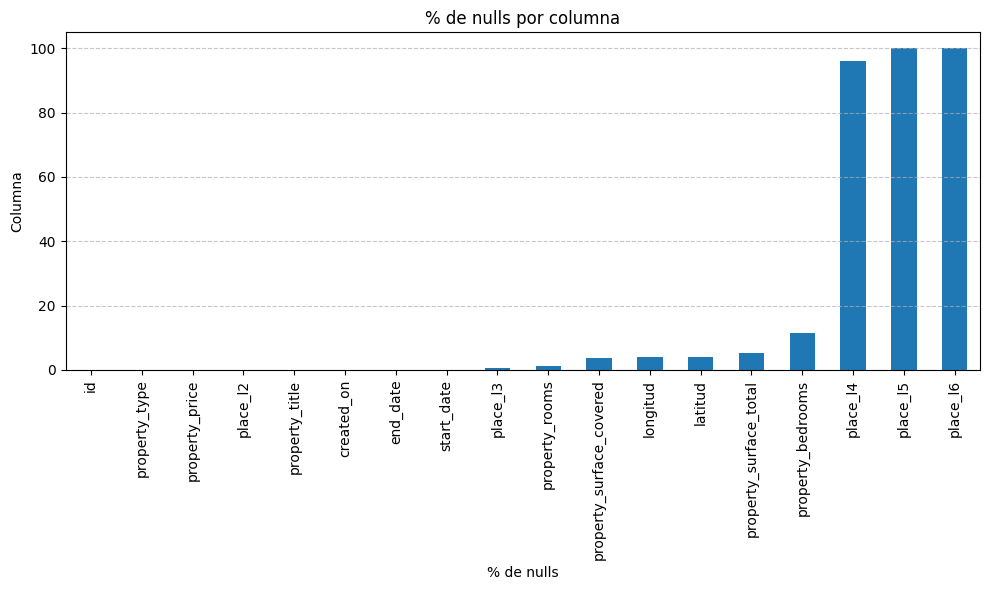

In [47]:
df_to_graph = ((df.isnull().sum() / len(df)) * 100).sort_values()

plot_graph(df_to_graph, "% de nulls por columna", "% de nulls", "Columna")

In [48]:
df = df.drop("place_l4", axis=1)
df = df.drop("place_l5", axis=1)
df = df.drop("place_l6", axis=1)

Por otro lado, las fechas no nos aportan una información relevante.
El ID es eliminado ya que no vamos a analizar individualmente cada propiedad, por lo que a nivel conjunto es un dato que no aporta.

In [49]:
df = df.drop("id", axis=1)
df = df.drop("start_date", axis=1)
df = df.drop("end_date", axis=1)
df = df.drop("created_on", axis=1)

Finalmente nos queda el siguiente dataframe

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75399 entries, 129124 to 74957
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitud                   72386 non-null  float64
 1   longitud                  72386 non-null  float64
 2   place_l2                  75399 non-null  object 
 3   place_l3                  75077 non-null  object 
 4   property_type             75399 non-null  object 
 5   property_rooms            74555 non-null  float64
 6   property_bedrooms         66668 non-null  float64
 7   property_surface_total    71545 non-null  float64
 8   property_surface_covered  72737 non-null  float64
 9   property_price            75399 non-null  float64
 10  property_title            75399 non-null  object 
dtypes: float64(7), object(4)
memory usage: 6.9+ MB


## B. Visualización de los datos

### Distribuciones


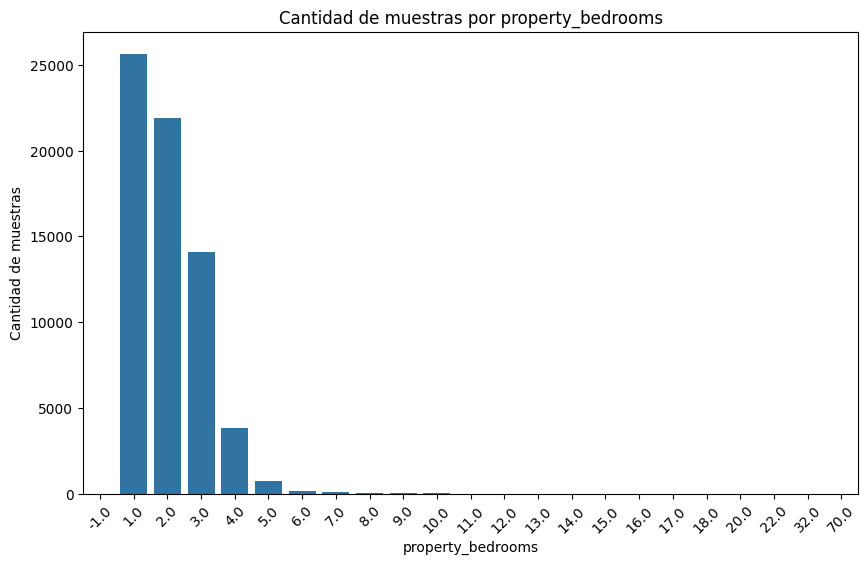

In [51]:
mostrar_distros_cuantitativas("property_bedrooms")

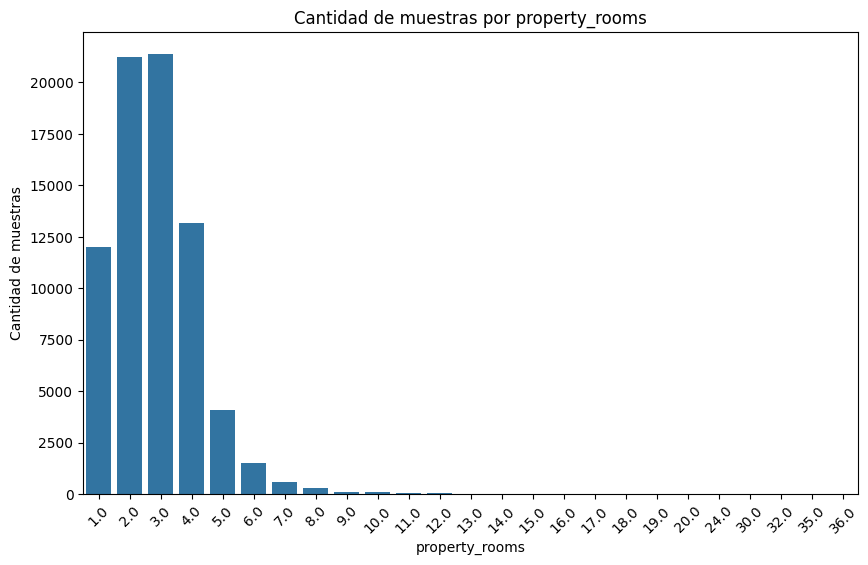

In [52]:
mostrar_distros_cuantitativas("property_rooms")

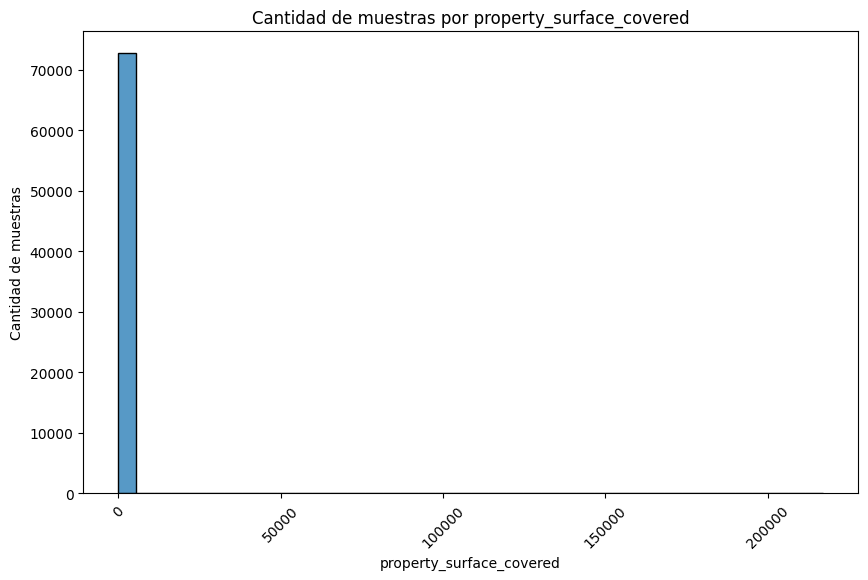

In [53]:
mostrar_distros_cuantitativas_continuas("property_surface_covered")

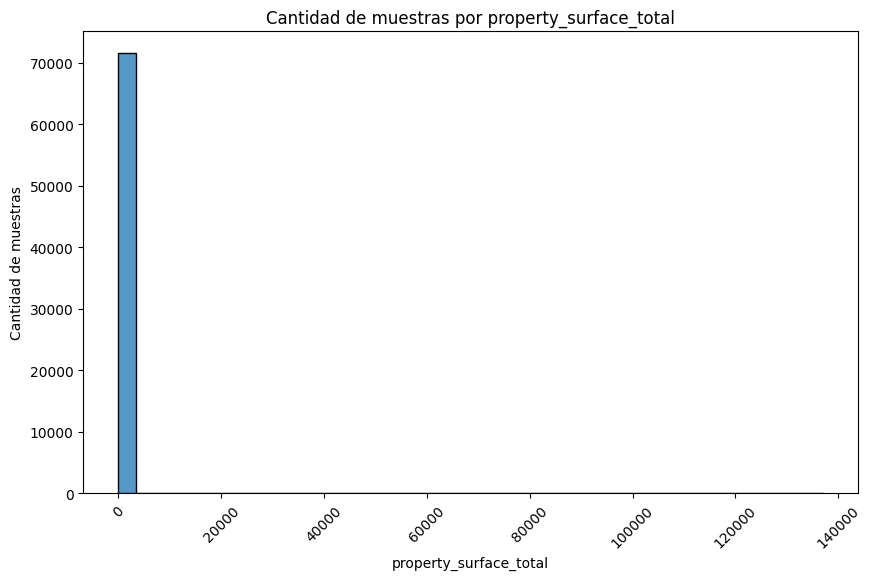

In [54]:
mostrar_distros_cuantitativas_continuas("property_surface_total")

En los graficos de distribuciones cuantitativas continuas apreciamos una gran acumulación. Para poder ver a detalle será necesario revisar los datos que agrandan la escala y generan esos cúmulos.

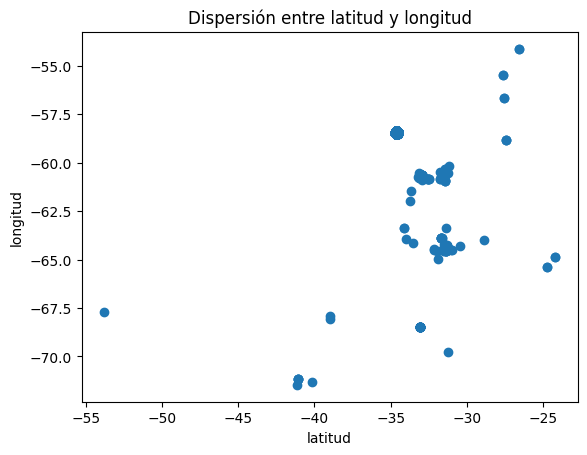

In [55]:
mostrar_dispersion("latitud","longitud")

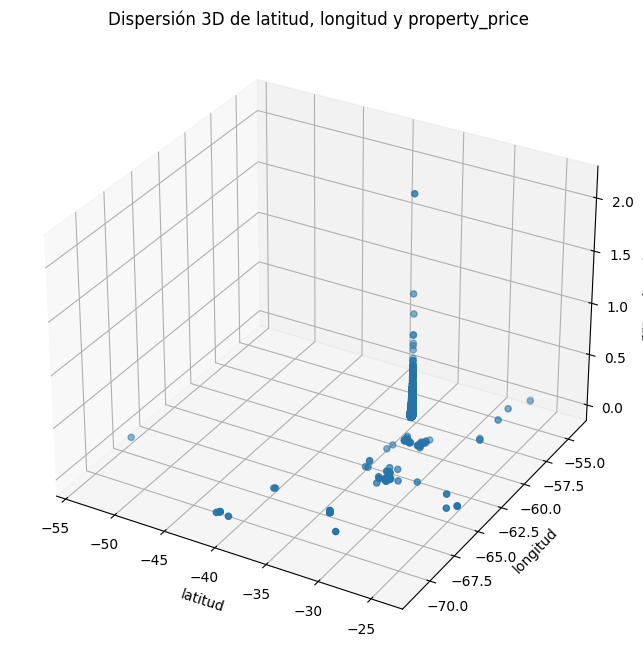

In [56]:
mostrar_dispersion_3d("latitud","longitud","property_price")

Vemos que hay una acumulación de muestras sobre un espacio relativamente reducido. El gráfico puede llegar a brindar informacion muy relevante.

Una posible sanitización de esta información puede darse de la siguiente manera:

Evaluar basandose en place_l3 las coordenadas de cada fila. Si estas corresponden al place_l3, entonces mantener su valor. Sino, modificar las coordenadas para que se ubiquen en el centro real de dicho place_l3.
Pueden utilizarse los mapas provistos por el gobierno de la ciudad para esta tarea.

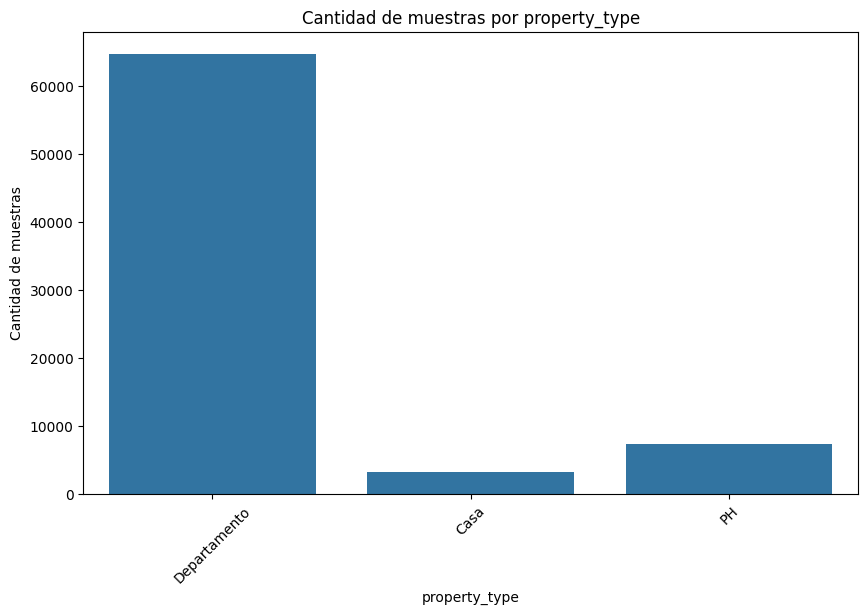

In [57]:
mostrar_distros_cuantitativas("property_type")

### Correlaciones

#### Heatmap

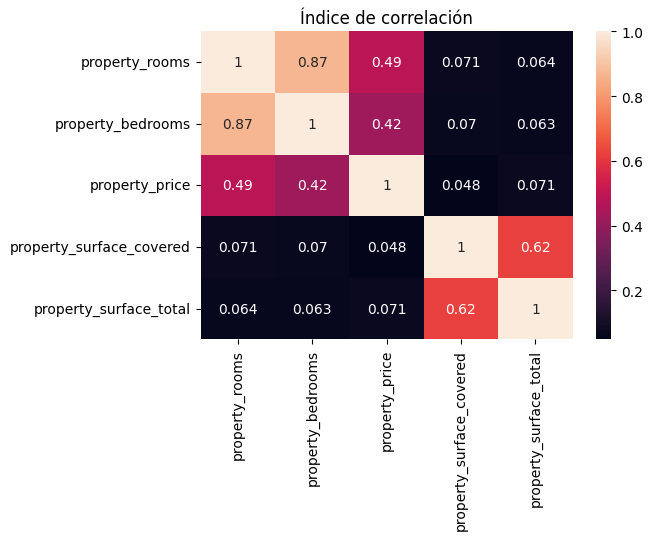

In [58]:
graficar_heatmap(["property_rooms", "property_bedrooms", "property_price", "property_surface_covered", "property_surface_total"])

La relacion entre superficie total y cubierta no es para nada la esperable para una grán ciudad como lo es Capital Federal con muchos edificios y pocos patios.
La relación entre cantidad de habitaciones y ambientes da la sensación de que debería ser aún más alta.
Sería interesante analizar algunas de estas correlaciones por tipo de propiedad, como así tambien ver como se comporta analizandolas por barrios.

#### Relación entre cantidad de habitaciones y de ambientes

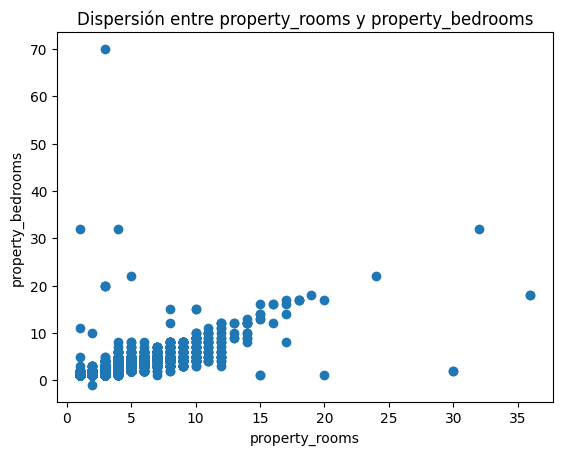

In [59]:
mostrar_dispersion("property_rooms","property_bedrooms")

Los puntos aislados levantan mucha sospecha. Además, considerando que toda habitación es un ambiente, es imposible que haya más de las primeras que de las segundas, por lo que se pueden ver unos cuantos errores.

#### Relacion entre superficies

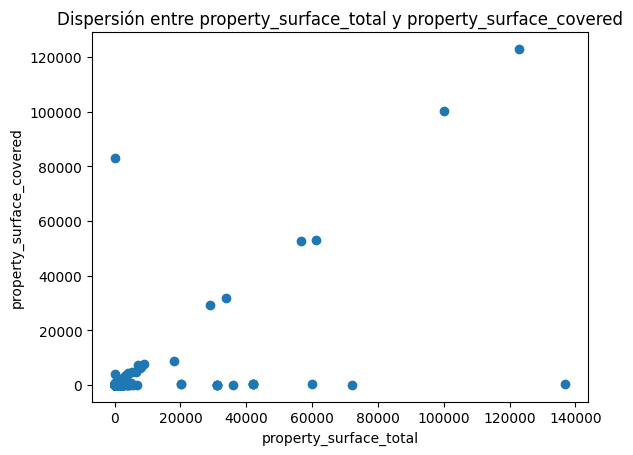

In [60]:
# grafico_dispersión_aproximación_lineal("property_surface_total","property_surface_covered")
mostrar_dispersion("property_surface_total","property_surface_covered")

Similar al caso anterior. La superficie cubierta es parte de la total. Si bien la tendencia tiene sentido, los valores que se encuentran por encima de la linea presentan un claro error.

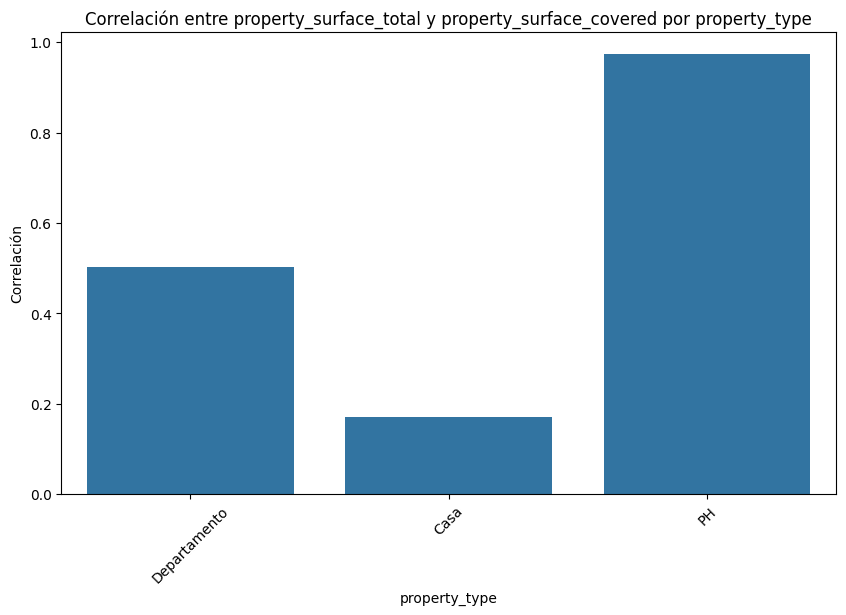

In [61]:
grafico_correlacion_por_categoría("property_surface_total","property_surface_covered","property_type")

Estas correlaciones se ven extrañas para ser capital federal. Uno no esperaría que las casas tengan poca relación entre los tipos de superficie, y mucho menos en los departamentos.

In [62]:
df_departamentos = df[df["property_type"] == "Departamento"]

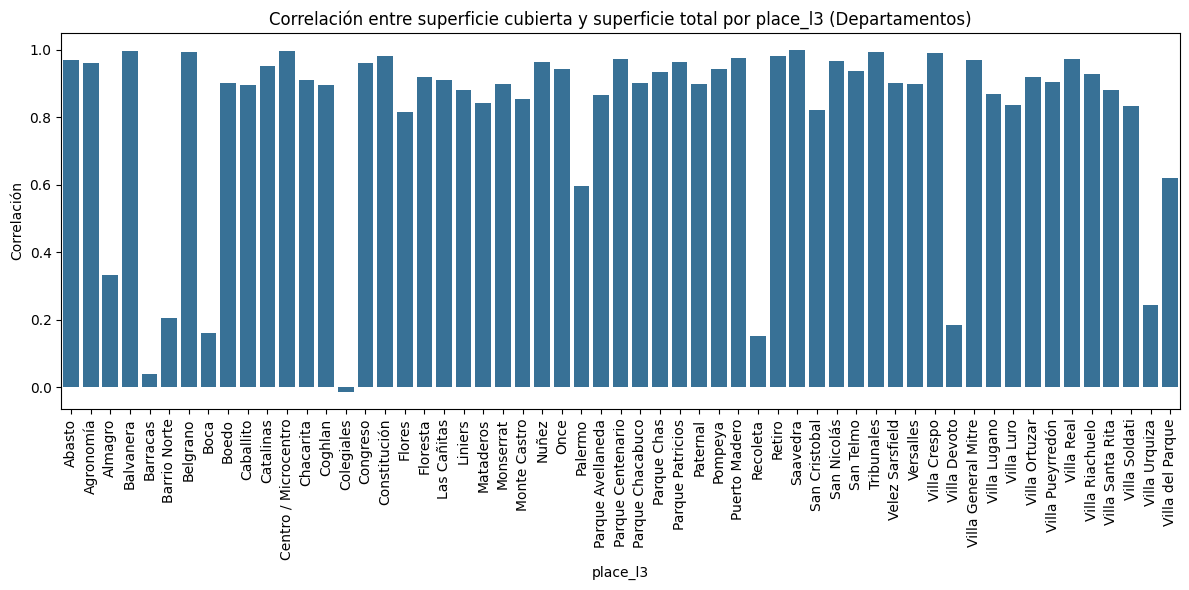

In [63]:
graficar_correlaciones_superficie_por_tipo_de_propiedad()

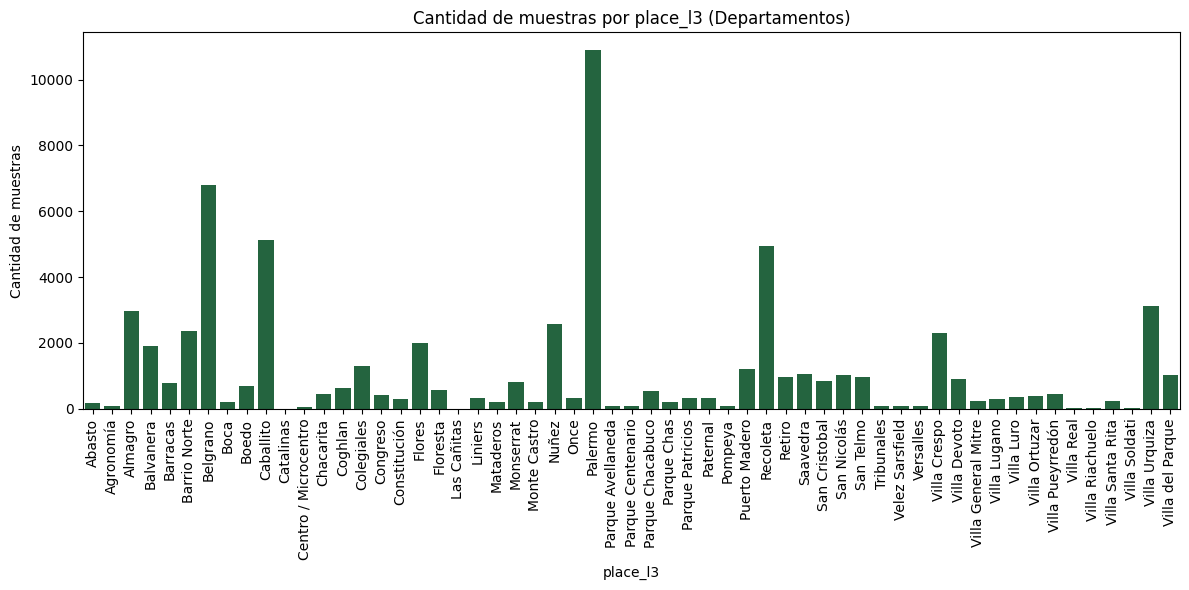

In [64]:
graficar_correlaciones_superficie_por_place_l3()

## C. Datos faltantes

#### Nulls generales

Luego de haber borrado las columnas con mayor proporción de datos faltantes y analizar tendencias, vamos a evaluar la calidad de la información de la que disponemos hasta el momento.

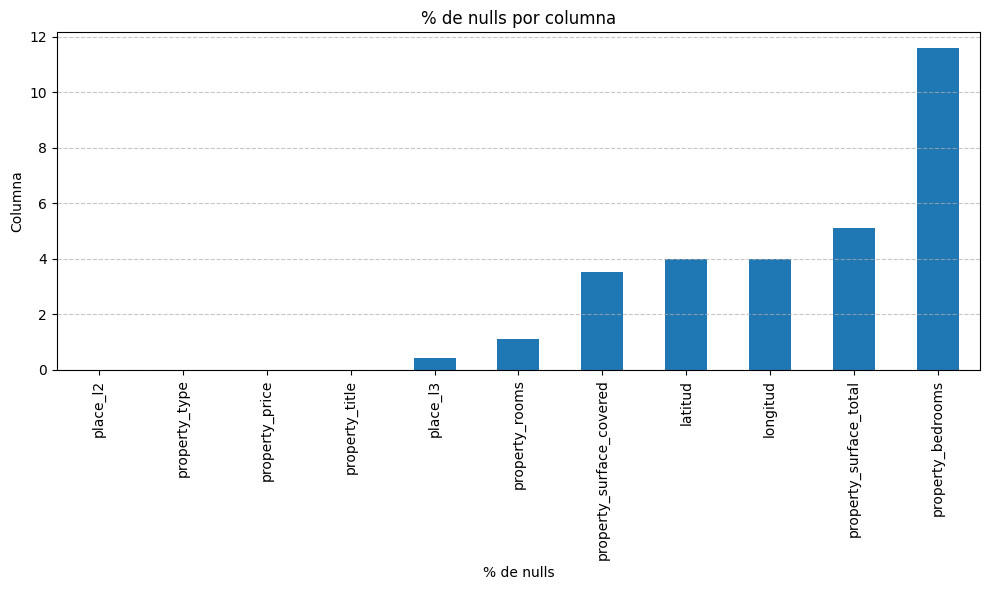

In [65]:
df_to_graph = ((df.isnull().sum() / len(df)) * 100).sort_values()

plot_graph(df_to_graph, "% de nulls por columna", "% de nulls", "Columna")

In [66]:
df.isnull().sum()

latitud                     3013
longitud                    3013
place_l2                       0
place_l3                     322
property_type                  0
property_rooms               844
property_bedrooms           8731
property_surface_total      3854
property_surface_covered    2662
property_price                 0
property_title                 0
dtype: int64

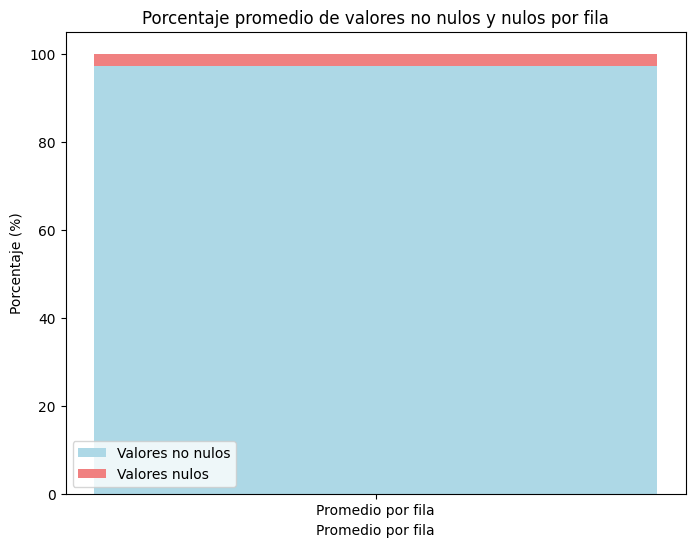

In [67]:
grafico_porcentaje_nulls_por_fila()

#### Tratamiento de nulls

##### Latitud y longitud

In [68]:
#TODO: Imputar de una de las siguientes formas:

#1. Valor promedio de lat y long de registros con el mismo place_l3 (o place_l4 si se decide no eliminarlo)
#2. Utilizar datos geográficos de la ciudad para imputar el centro del place_l3 en las corrdenadas.

#Por el momento, dejamos los datos null ya que aún no trabajamos con esas columnas

##### Place_l3

Siendo que representa un porcentaje minúsculo de los datos y el dato es crucial, eliminamos las filas.

Una posible opción a futuro es imputarlo en base a las coordenadas.

In [69]:
df = df.dropna(subset=["place_l3"])

##### Cantidad de habitaciones y de ambientes

Partiendo de la primicia de que toda habitación es un ambiente y no al reves, y que por lo general existe 1 ambiente más que habitaciones (el living), vamos a hacer lo siguiente:

In [70]:
#1. Eliminar las filas donde ambos datos son null ya que no contamos con la información suficiente para imputar al otro dato. En una futura versión estos datos podrían llegar a imputarse en base a publicaciones de similares características.
df = df.dropna(subset=["property_bedrooms", "property_rooms"])

#2. Imputar la cantidad de habitaciones como cantidad de ambientes - 1
df["property_bedrooms"].fillna(df["property_rooms"] - 1, inplace=True)

#3. Imputar la cantidad de ambientes como cantidad de habitaciones + 1
df["property_rooms"].fillna(df["property_bedrooms"] + 1, inplace=True)

##### Superficie cubierta y total

Siguiendo una lógica similar a la de las habitaciones y ambientes, el total de superficie esta compuesto por la suma se superficie cubierta y descubierta, imputamos una con el valor de la otra.

Por el momento este es un punto de mejora ya que, por lo visto en los gráficos, la relación entre ambos no es lo suficientemente alta como para imputar de esta forma con un alto indnice de confianza.
Por otro lado, por conocimiento del negocio sabemos que en Capital Federal los espacios abiertos en propiedades son más bien reducidos, por lo que sería esperable que la superficie total sea igual o apenas superior a la superficie cubierta.

In [71]:
#1. Eliminar las filas donde ambos datos son null ya que no contamos con la información suficiente para imputar al otro dato. En una futura versión estos datos podrían llegar a imputarse en base a publicaciones de similares características.
df = df.dropna(subset=["property_surface_covered", "property_surface_total"])

#2. Imputar la superficie cubierta como superficie total
df["property_surface_covered"].fillna(df["property_surface_total"], inplace=True)

#3. Imputar superficie total como superficie cubierta
df["property_surface_total"].fillna(df["property_surface_covered"], inplace=True)

#### Conclusion parcial
En este punto ya no deberíamos presentar nulls (exceptuando los de latitud y longitud que dejamos pasar).

In [72]:
df.isnull().sum()

latitud                     2300
longitud                    2300
place_l2                       0
place_l3                       0
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered       0
property_price                 0
property_title                 0
dtype: int64

Nuestra idea para el proximo checkpoint es intentar salvar estos datos que tienen ambas coordenadas con valor nulo, pero en principio los descartamos.

In [73]:
df = df.dropna()

#### Datos mal ingresados

##### Precio

In [74]:
df[df["property_price"] <= 0].shape

(0, 11)

##### Latitud y longitud

Corroborar utilizando datos geográficos de la ciudad

No hay datos de precios mal ingresados. Aún puede haber precios ilógicos, pero no hay negativos ni nulos.

##### Habitaciones y ambientes

En aquellas con mas ambientes que habitaciones se hace la corrección basandose en el título de la publicación.
En aquellas con uno de los valores negativos las elimino directamente ya que representan una ínfima cantidad

In [75]:
df[df["property_bedrooms"] > df["property_rooms"]]

# En un vistazo rápido se ve que el property_title en estos casos coincide con la cantidad de ambientes señalados, por lo que el valor a corregir es la cantidad de habitaciones

df.loc[df["property_bedrooms"] > df["property_rooms"], "property_bedrooms"] = df["property_rooms"] - 1


df = df.drop(df[df["property_rooms"] <= 0].index)
df = df.drop(df[df["property_bedrooms"] < 0].index)


##### Superficies

En aquellas con mayor superficie cubierta que total, invierto los valores.

In [76]:
filas_erroneas = df["property_surface_total"] < df["property_surface_covered"]

df.loc[filas_erroneas, ["property_surface_total", "property_surface_covered"]] = df.loc[filas_erroneas, ["property_surface_covered", "property_surface_total"]].values


df = df.drop(df[df["property_surface_total"] <= 0].index)
df = df.drop(df[df["property_surface_covered"] < 0].index)


## D. Valores atípicos

### Creacion de nuevas columnas


#### Precio por metro cuadrado

In [77]:
df["total_m2_price"] = df["property_price"] / df["property_surface_total"]
df["covered_m2_price"] = df["property_price"] / df["property_surface_covered"]

### Detectar valores atípicos

#### Superficie total y cubierta

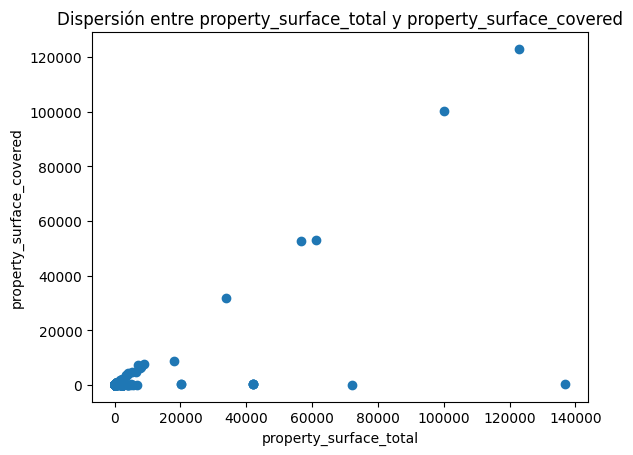

In [78]:
mostrar_dispersion("property_surface_total","property_surface_covered")

Vemos que hay un cúmulo importante de datos en la esquina inferior izquierda del gráfico, y que muy alejados de estos se encuentran otros datos más aislados.
Estos últimos los consideramos outlayers a eliminar.
Siguiendo la lógica del negocio, es impensable encontrar propiedades con tales dimensiones en una ciudad grande como Capital Federal, e incluso fuera de la misma.

A traves de la mediana vamos a calcular un margen generoso (7x) y eliminar a aquellos registros que escapen de este margen.

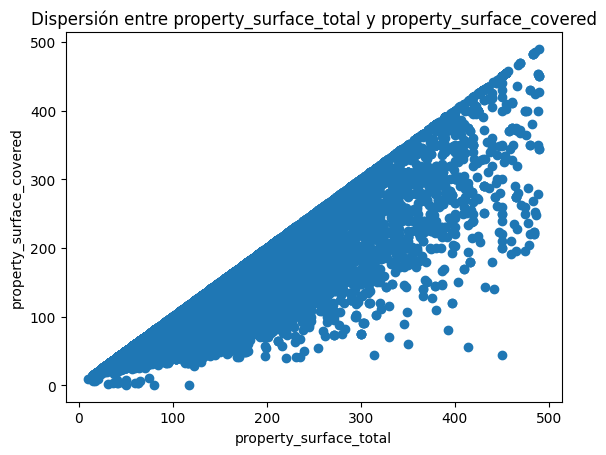

In [79]:
# Calcular la mediana de "property_surface_total"
mediana = df["property_surface_total"].median()

# Definir el límite superior
limite_superior = mediana * 7

# Filtrar el DataFrame para eliminar valores atípicos
df = df[df["property_surface_total"] <= limite_superior]


mostrar_dispersion("property_surface_total","property_surface_covered")

El gráfico resultante muestra que la imputación realizada previamente satisfactoriamente corrigió los casos donde la superficie cubierta era mayor a la superficie total.
Tambien deja ver un gráfico bastante esperable.

#### Habitaciones y ambientes

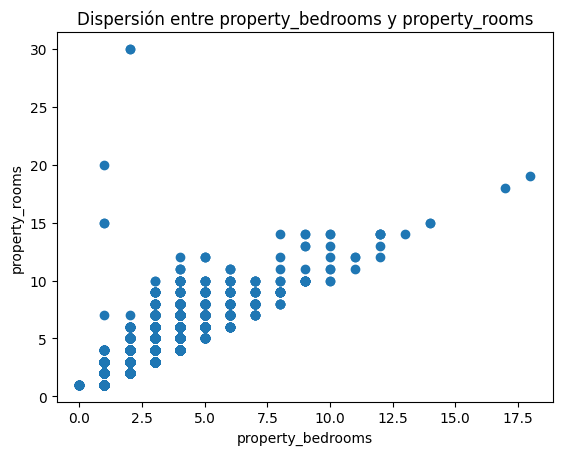

In [80]:
# Dispesión de habitaciones y ambientes

mostrar_dispersion("property_bedrooms","property_rooms")

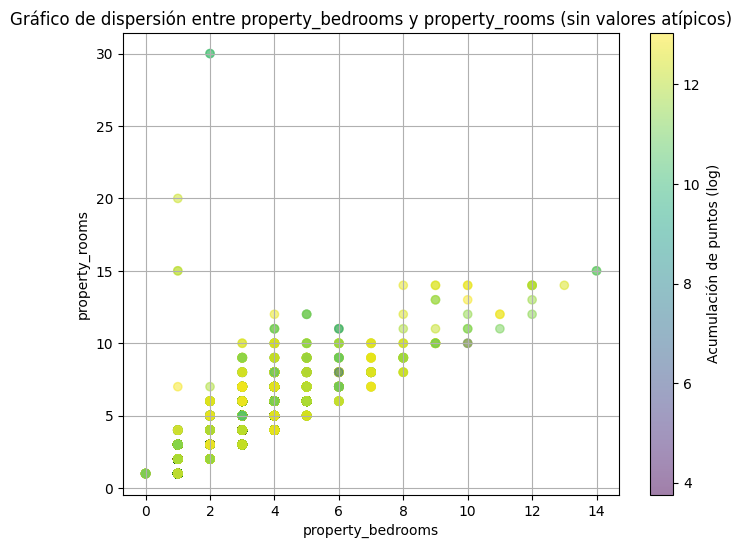

In [81]:
# Calcular la mediana de "property_surface_total"
mediana = df["property_bedrooms"].median()

# Definir el límite superior
limite_superior = mediana * 7

# Filtrar el DataFrame para eliminar valores atípicos
df = df[df["property_bedrooms"] <= limite_superior]

# Crear el gráfico de dispersión con la gama de colores para la acumulación de puntos
plt.figure(figsize=(8, 6))
plt.scatter(df["property_bedrooms"], df["property_rooms"], c=np.log(df.index + 1), cmap="viridis", alpha=0.5)
plt.title("Gráfico de dispersión entre property_bedrooms y property_rooms (sin valores atípicos)")
plt.xlabel("property_bedrooms")
plt.ylabel("property_rooms")
plt.colorbar(label="Acumulación de puntos (log)")
plt.grid(True)
plt.show()


#### Precios

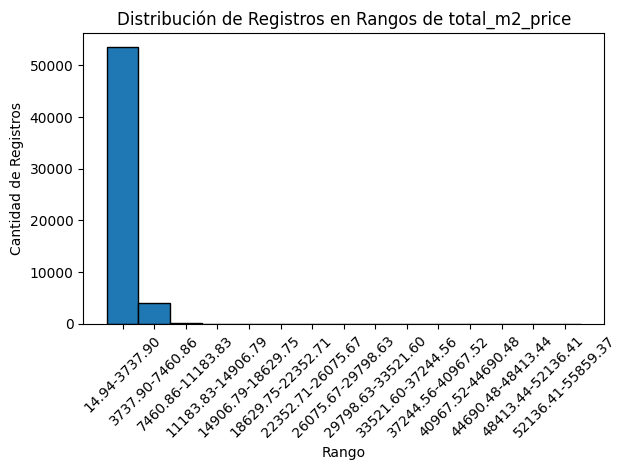

In [82]:
num_bins = 15
bin_width = (df["total_m2_price"].max() - df["total_m2_price"].min()) / num_bins
bins = [df["total_m2_price"].min() + i * bin_width for i in range(num_bins + 1)]

hist, bins = np.histogram(df["total_m2_price"], bins=bins)

plt.bar(range(len(hist)), hist, width=1, edgecolor="black")

plt.xlabel("Rango")
plt.ylabel("Cantidad de Registros")
plt.title("Distribución de Registros en Rangos de total_m2_price")

plt.xticks(range(len(hist)), [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(hist))], rotation=45)

plt.tight_layout()
plt.show()

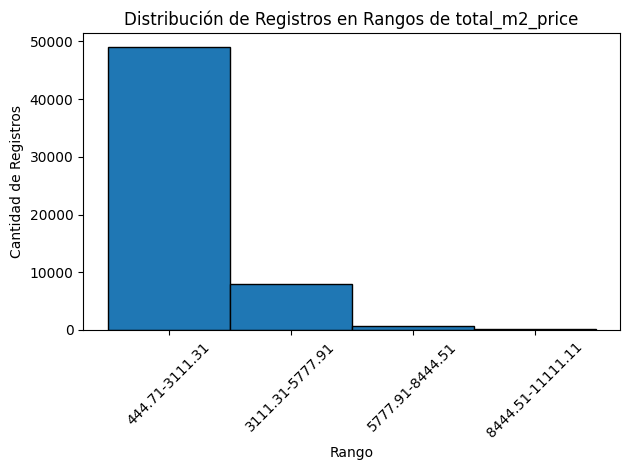

In [83]:
# Vemos que hay numeros irrisorios. Tomo la media y elimino en un rango de 5 veces menor y 5 veces mayor
mediana_total_m2_price = df["total_m2_price"].median()

limite_inferior = mediana_total_m2_price / 5
limite_superior = mediana_total_m2_price * 5

df = nuevo_df = df[(df["total_m2_price"] >= limite_inferior) & (df["total_m2_price"] <= limite_superior)]

num_bins = 4
bin_width = (df["total_m2_price"].max() - df["total_m2_price"].min()) / num_bins
bins = [df["total_m2_price"].min() + i * bin_width for i in range(num_bins + 1)]

hist, bins = np.histogram(df["total_m2_price"], bins=bins)

plt.bar(range(len(hist)), hist, width=1, edgecolor="black")

plt.xlabel("Rango")
plt.ylabel("Cantidad de Registros")
plt.title("Distribución de Registros en Rangos de total_m2_price")

plt.xticks(range(len(hist)), [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(hist))], rotation=45)

plt.tight_layout()
plt.show()

In [84]:
# Despues de revisar todos estos valores atípicos vemos que borramos aprox 5k filas de las 75399 con las que empezamos. No me parece mal
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57814 entries, 115426 to 134904
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitud                   57814 non-null  float64
 1   longitud                  57814 non-null  float64
 2   place_l2                  57814 non-null  object 
 3   place_l3                  57814 non-null  object 
 4   property_type             57814 non-null  object 
 5   property_rooms            57814 non-null  float64
 6   property_bedrooms         57814 non-null  float64
 7   property_surface_total    57814 non-null  float64
 8   property_surface_covered  57814 non-null  float64
 9   property_price            57814 non-null  float64
 10  property_title            57814 non-null  object 
 11  total_m2_price            57814 non-null  float64
 12  covered_m2_price          57814 non-null  float64
dtypes: float64(9), object(4)
memory usage: 6.2+ MB


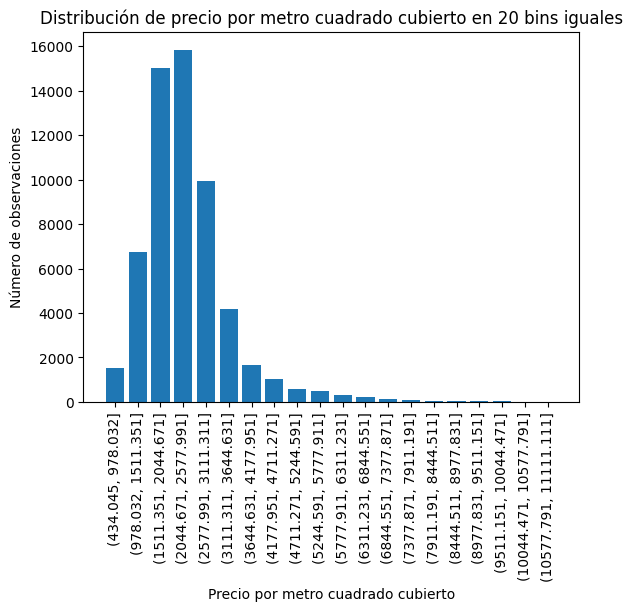

In [85]:
# Analizamos la relación entre los m2 cubiertos y la cantidad de ambientes

df["price_per_covered_square_meter"] = df["property_price"] / df["property_surface_total"]

bins = pd.cut(df["price_per_covered_square_meter"], bins=20)

price_counts = bins.value_counts().sort_index()

plt.bar(range(len(price_counts)), price_counts, tick_label=price_counts.index.astype(str))
plt.title("Distribución de precio por metro cuadrado cubierto en 20 bins iguales")
plt.xlabel("Precio por metro cuadrado cubierto")
plt.ylabel("Número de observaciones")
plt.xticks(rotation=90)
plt.show()

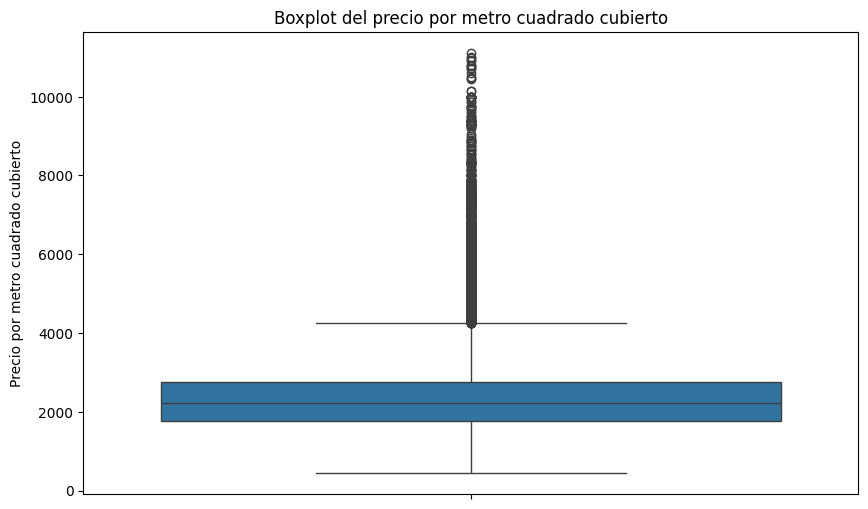

In [86]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y="price_per_covered_square_meter")
plt.title("Boxplot del precio por metro cuadrado cubierto")
plt.ylabel("Precio por metro cuadrado cubierto")
plt.show()

In [87]:
Q1 = df["price_per_covered_square_meter"].quantile(0.25)
Q3 = df["price_per_covered_square_meter"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df[(df["price_per_covered_square_meter"] >= lower_bound) & (df["price_per_covered_square_meter"] <= upper_bound)]

percentage_outliers = 100 - len(df_filtered) / len(df) * 100
print("Porcentaje de outliers eliminados: ", percentage_outliers)

df = df_filtered.copy()

Porcentaje de outliers eliminados:  4.777389559622236


# 2. Agrupamiento

Antes de buscar agrupar, necesitamos dejar el df unicamente con valores numéricos, asique pasamos a realizar eso.

In [88]:
df = pd.get_dummies(df, columns=["property_type"])

In [89]:
df.drop(columns=["place_l2", "property_title"], inplace=True)
df.rename(columns={"property_type_Casa": "Casa", "property_type_Departamento": "Departamento", "property_type_PH": "PH"}, inplace=True)
df["Casa"] = df["Casa"].astype(int)
df["Departamento"] = df["Departamento"].astype(int)
df["PH"] = df["PH"].astype(int)

In [90]:
top_3_barrios = df["place_l3"].value_counts().nlargest(3).index.tolist()

for value in top_3_barrios:
    df[value] = (df["place_l3"] == value).astype(int)

df["Otro barrio"] = (~(df["place_l3"].isin(top_3_barrios))).astype(int)

df.drop(columns=["place_l3"], inplace=True)

In [91]:
df.head(5)

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,total_m2_price,covered_m2_price,price_per_covered_square_meter,Casa,Departamento,PH,Palermo,Belgrano,Caballito,Otro barrio
115426,-34.598103,-58.442806,1.0,1.0,30.0,27.0,79000.0,2633.333333,2925.925926,2633.333333,0,1,0,0,0,0,1
256212,-34.583233,-58.403942,4.0,3.0,200.0,200.0,790000.0,3950.000000,3950.000000,3950.000000,0,1,0,1,0,0,0
304754,-34.578438,-58.462492,4.0,3.0,79.0,79.0,178900.0,2264.556962,2264.556962,2264.556962,0,1,0,0,0,0,1
259655,-34.597612,-58.419316,2.0,1.0,53.0,49.0,143900.0,2715.094340,2936.734694,2715.094340,0,1,0,1,0,0,0
172350,-34.612999,-58.424641,3.0,2.0,73.0,63.0,110000.0,1506.849315,1746.031746,1506.849315,0,1,0,0,0,0,1


Buscamos el SSE (Error Sum of Squares) con el atributo inertia_ de una instancia de KMeans.

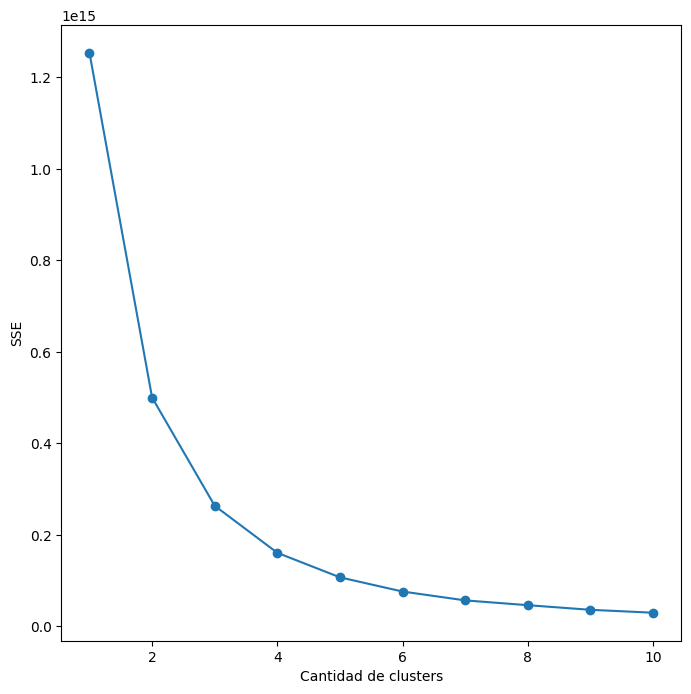

In [92]:
sse = []
k_values = list(range(1, 11))

for k in k_values:
    km = KMeans(n_clusters = k)
    km.fit(df)
    sse.append(km.inertia_)

plt.figure(figsize=(8, 8))
plt.plot(k_values, sse, "-o")
plt.xlabel("Cantidad de clusters")
plt.ylabel("SSE")
plt.show()

Notamos que el error del SSE es demasiado alto, en principio no sabemos a que se debe, pero es sospechoso ...

Vemos que el error se empieza a "planchar" cuando la cantidad clusters es >= 2.

In [93]:
for k in range(2, 5):
    clusterer = KMeans(n_clusters=k, random_state=0)
    preds = clusterer.fit_predict(df)

    score = silhouette_score(df, preds)
    print(f"Para {k} grupos el silhouette score es {score}")

Para 2 grupos el silhouette score es 0.7372594747315344
Para 3 grupos el silhouette score es 0.6505986179520716
Para 4 grupos el silhouette score es 0.59711259207373


### Análisis separando el df en dos grupos

In [94]:
kmeans = KMeans(n_clusters=2, random_state=0) 
kmeans.fit(df)
grupos = kmeans.predict(df)

In [95]:
grupo1 = df[grupos == 0]
grupo2 = df[grupos == 1]

In [96]:
grupo1.shape, grupo2.shape

((48876, 17), (6176, 17))

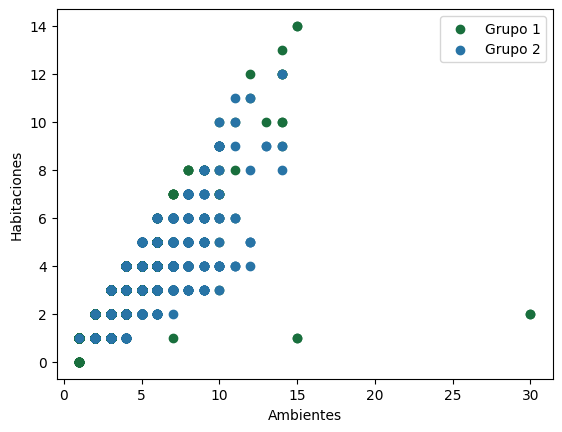

In [97]:
plt.scatter(grupo1["property_rooms"], grupo1["property_bedrooms"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_rooms"], grupo2["property_bedrooms"], color=COLORES[1], label = "Grupo 2")
plt.xlabel("Ambientes")
plt.ylabel("Habitaciones")
plt.legend()
plt.show()

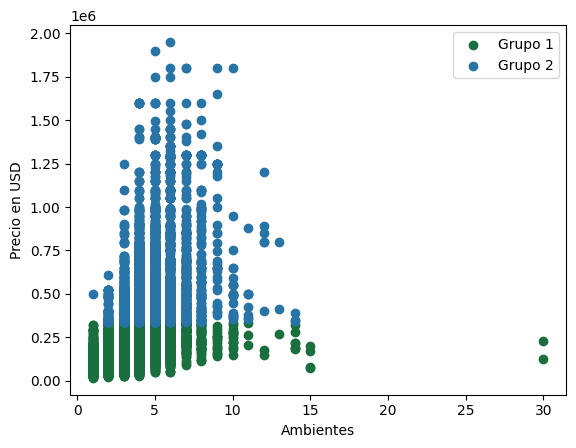

In [98]:
plt.scatter(grupo1["property_rooms"], grupo1["property_price"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_rooms"], grupo2["property_price"], color=COLORES[1], label = "Grupo 2")
plt.xlabel("Ambientes")
plt.ylabel("Precio en USD")
plt.legend()
plt.show()

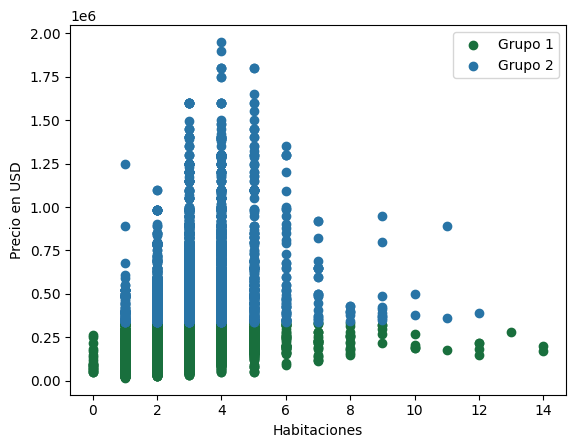

In [99]:
plt.scatter(grupo1["property_bedrooms"], grupo1["property_price"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_bedrooms"], grupo2["property_price"], color=COLORES[1], label = "Grupo 2")
plt.xlabel("Habitaciones")
plt.ylabel("Precio en USD")
plt.legend()
plt.show()

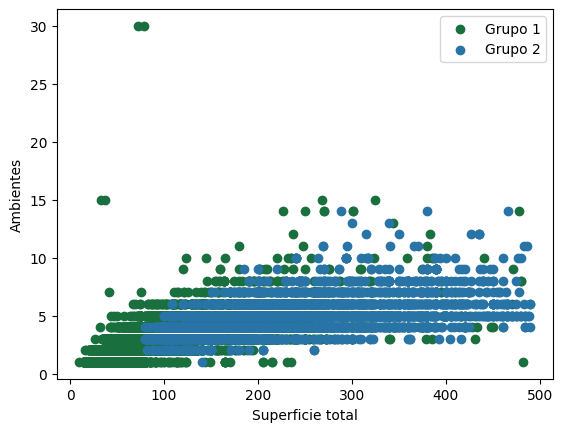

In [100]:
plt.scatter(grupo1["property_surface_total"], grupo1["property_rooms"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_surface_total"], grupo2["property_rooms"], color=COLORES[1], label = "Grupo 2")
plt.xlabel("Superficie total")
plt.ylabel("Ambientes")
plt.legend()
plt.show()

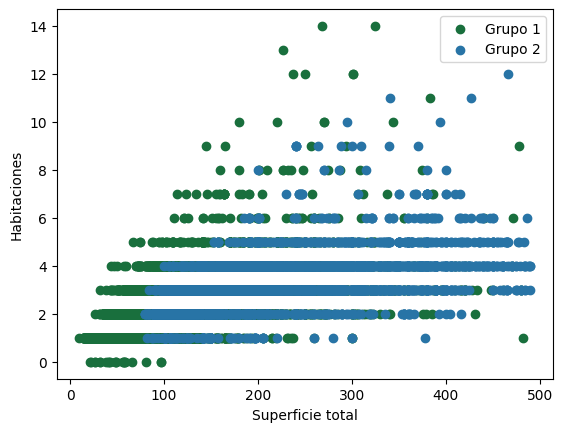

In [101]:
plt.scatter(grupo1["property_surface_total"], grupo1["property_bedrooms"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_surface_total"], grupo2["property_bedrooms"], color=COLORES[1], label = "Grupo 2")
plt.xlabel("Superficie total")
plt.ylabel("Habitaciones")
plt.legend()
plt.show()

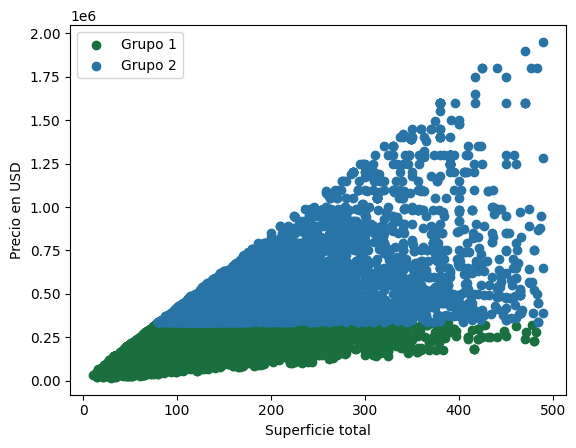

In [102]:
plt.scatter(grupo1["property_surface_total"], grupo1["property_price"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_surface_total"], grupo2["property_price"], color=COLORES[1], label = "Grupo 2")
plt.xlabel("Superficie total")
plt.ylabel("Precio en USD")
plt.legend()
plt.show()

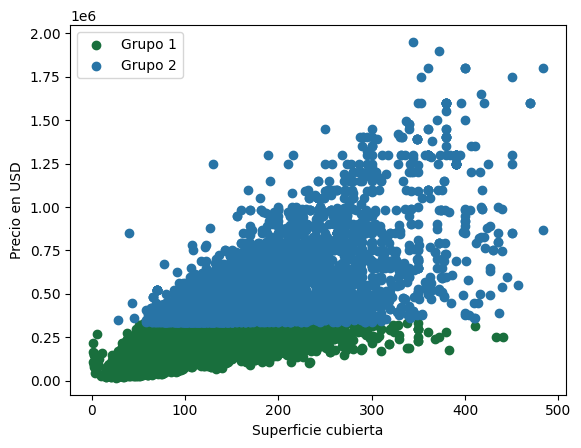

In [103]:
plt.scatter(grupo1["property_surface_covered"], grupo1["property_price"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_surface_covered"], grupo2["property_price"], color=COLORES[1], label = "Grupo 2")
plt.xlabel("Superficie cubierta")
plt.ylabel("Precio en USD")
plt.legend()
plt.show()

Por estos graficos podemos ver que la tendencia indica que los grupos están diferenciados de acuerdo al valor de la propiedad en USD.

In [104]:
barrios_caba = gpd.read_file("/home/taiel/Documentos/FIUBA/2024_C1/OrgaDeDatos/7506R-1C2024-GRUPO01/TP1/barrios.geojson")
p = gpd.GeoSeries(barrios_caba.geometry)

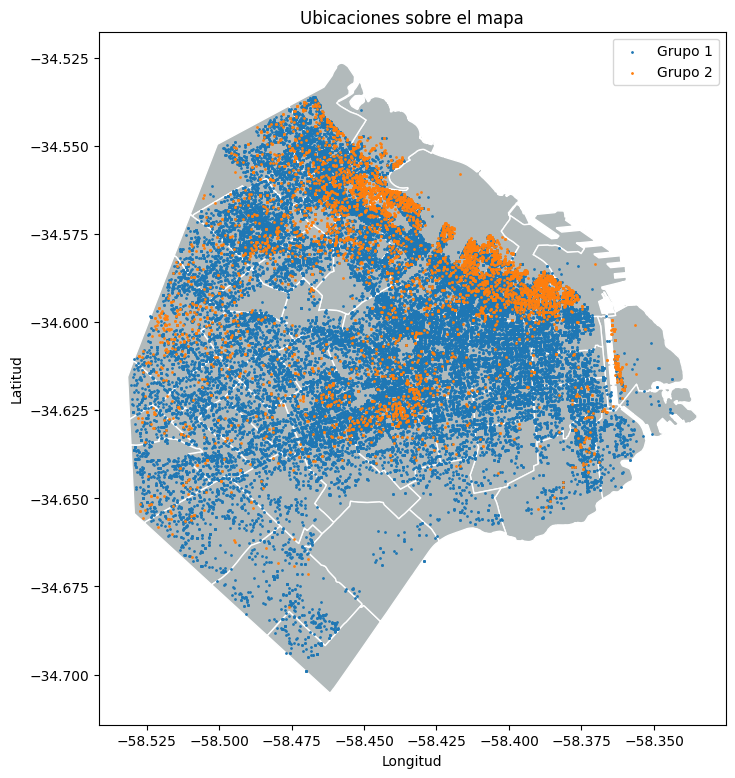

In [105]:
p.plot(color=GRIS, edgecolor="white", figsize=(9,9))

plt.scatter(grupo1["longitud"], y=grupo1["latitud"], s = 1, label = "Grupo 1")
plt.scatter(grupo2["longitud"], y=grupo2["latitud"], s = 1, label = "Grupo 2")
plt.title("Ubicaciones sobre el mapa")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend()
plt.show()

### Análisis separando el df en tres grupos

In [106]:
kmeans = KMeans(n_clusters=3, random_state=0) 
kmeans.fit(df)
grupos = kmeans.predict(df)

In [107]:
grupo1 = df[grupos == 0]
grupo2 = df[grupos == 1]
grupo3 = df[grupos == 2]

In [108]:
grupo1.shape, grupo2.shape, grupo3.shape

((41366, 17), (1908, 17), (11778, 17))

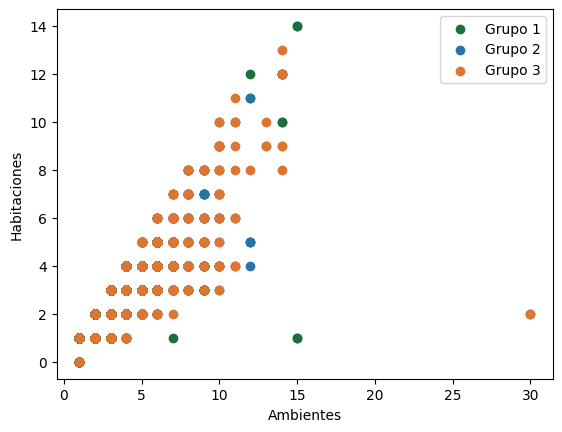

In [109]:
plt.scatter(grupo1["property_rooms"], grupo1["property_bedrooms"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_rooms"], grupo2["property_bedrooms"], color=COLORES[1], label = "Grupo 2")
plt.scatter(grupo3["property_rooms"], grupo3["property_bedrooms"], color=COLORES[2], label = "Grupo 3")
plt.xlabel("Ambientes")
plt.ylabel("Habitaciones")
plt.legend()
plt.show()

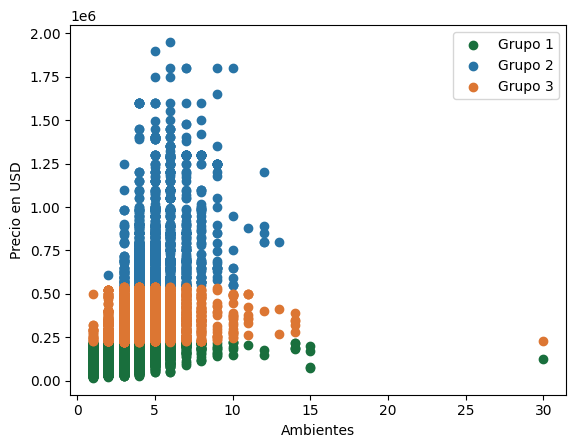

In [110]:
plt.scatter(grupo1["property_rooms"], grupo1["property_price"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_rooms"], grupo2["property_price"], color=COLORES[1], label = "Grupo 2")
plt.scatter(grupo3["property_rooms"], grupo3["property_price"], color=COLORES[2], label = "Grupo 3")
plt.xlabel("Ambientes")
plt.ylabel("Precio en USD")
plt.legend()
plt.show()

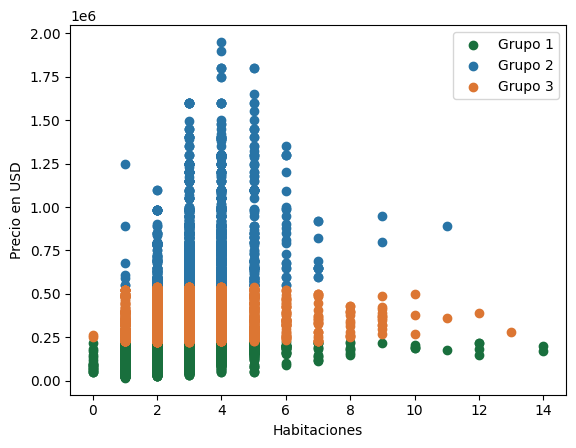

In [111]:
plt.scatter(grupo1["property_bedrooms"], grupo1["property_price"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_bedrooms"], grupo2["property_price"], color=COLORES[1], label = "Grupo 2")
plt.scatter(grupo3["property_bedrooms"], grupo3["property_price"], color=COLORES[2], label = "Grupo 3")
plt.xlabel("Habitaciones")
plt.ylabel("Precio en USD")
plt.legend()
plt.show()

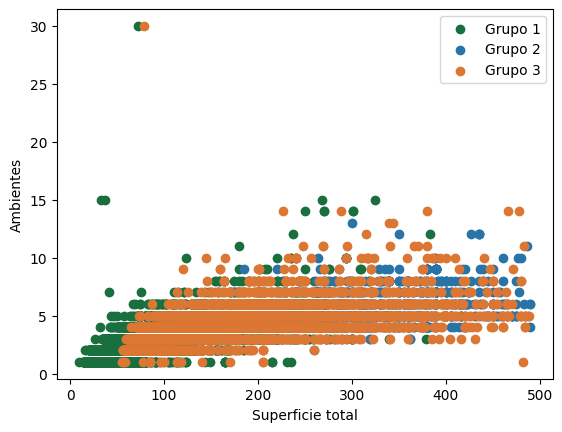

In [112]:
plt.scatter(grupo1["property_surface_total"], grupo1["property_rooms"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_surface_total"], grupo2["property_rooms"], color=COLORES[1], label = "Grupo 2")
plt.scatter(grupo3["property_surface_total"], grupo3["property_rooms"], color=COLORES[2], label = "Grupo 3")
plt.xlabel("Superficie total")
plt.ylabel("Ambientes")
plt.legend()
plt.show()

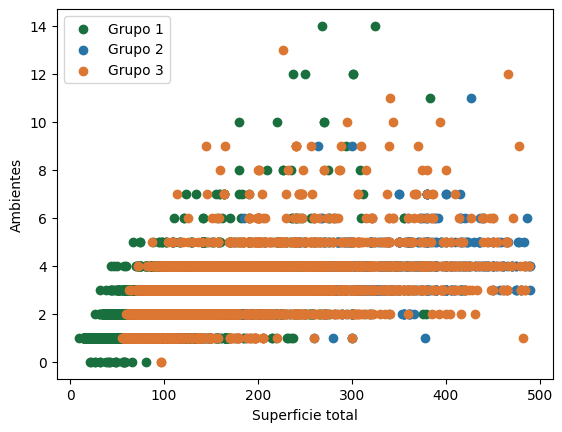

In [113]:
plt.scatter(grupo1["property_surface_total"], grupo1["property_bedrooms"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_surface_total"], grupo2["property_bedrooms"], color=COLORES[1], label = "Grupo 2")
plt.scatter(grupo3["property_surface_total"], grupo3["property_bedrooms"], color=COLORES[2], label = "Grupo 3")
plt.xlabel("Superficie total")
plt.ylabel("Ambientes")
plt.legend()
plt.show()

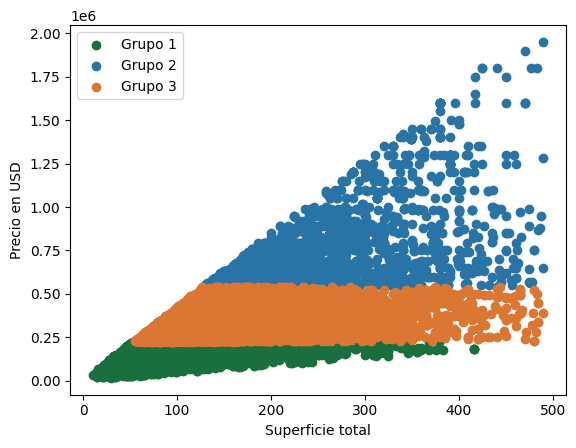

In [114]:
plt.scatter(grupo1["property_surface_total"], grupo1["property_price"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_surface_total"], grupo2["property_price"], color=COLORES[1], label = "Grupo 2")
plt.scatter(grupo3["property_surface_total"], grupo3["property_price"], color=COLORES[2], label = "Grupo 3")
plt.xlabel("Superficie total")
plt.ylabel("Precio en USD")
plt.legend()
plt.show()

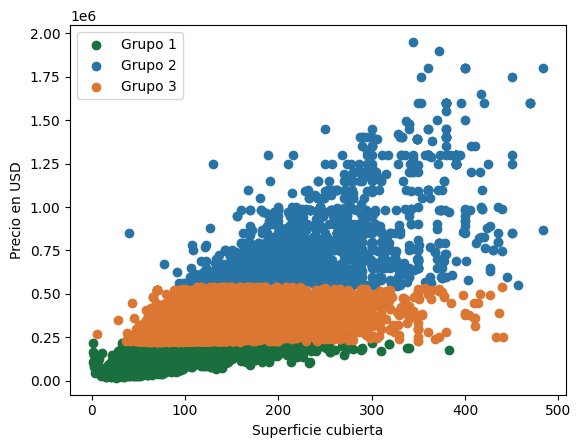

In [115]:
plt.scatter(grupo1["property_surface_covered"], grupo1["property_price"], color=COLORES[0], label = "Grupo 1")
plt.scatter(grupo2["property_surface_covered"], grupo2["property_price"], color=COLORES[1], label = "Grupo 2")
plt.scatter(grupo3["property_surface_covered"], grupo3["property_price"], color=COLORES[2], label = "Grupo 3")
plt.xlabel("Superficie cubierta")
plt.ylabel("Precio en USD")
plt.legend()
plt.show()

Vemos que nuevamente la tendencia de los clusters es dividirse segun el precio de la propiedad en USD.

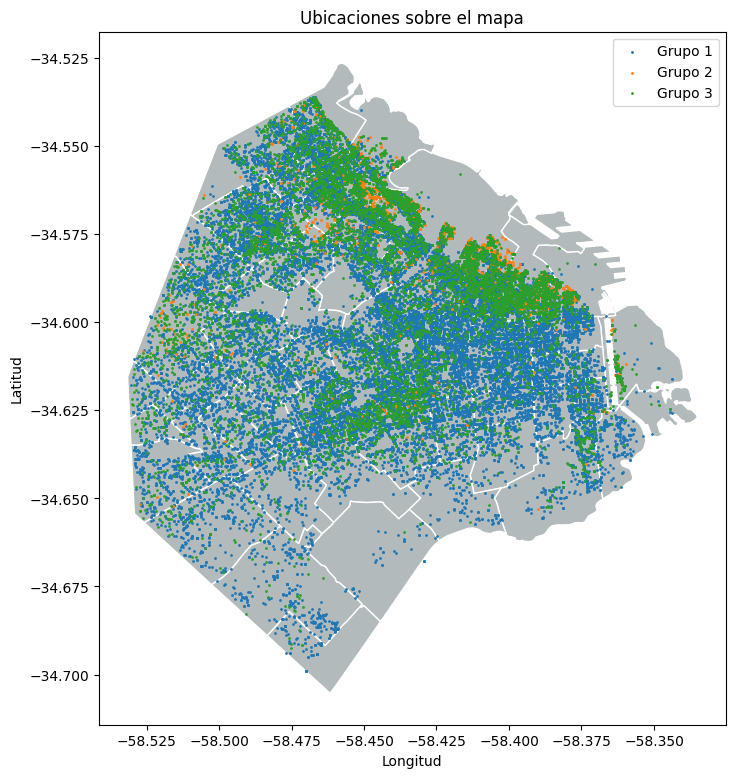

In [116]:
p.plot(color=GRIS, edgecolor="white", figsize=(9,9))

plt.scatter(grupo1["longitud"], grupo1["latitud"], s = 1, label = "Grupo 1")
plt.scatter(grupo2["longitud"], grupo2["latitud"], s = 1, label = "Grupo 2")
plt.scatter(grupo3["longitud"], grupo3["latitud"], s = 1,label = "Grupo 3")
plt.title("Ubicaciones sobre el mapa")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend()
plt.show()